# Demographics Data (Geospatial)

This tutorial will guide you through geospatial (GIS) demographic datasets, such as population, income, commuting modes, and travel demands. The primary data source is the US Census.

_For demographics of MBTA riders ([the MBTA Rider Census](https://www.mbta.com/performance-metrics/the-rider-census)), view the last section of our [MBTA ridership data tutorial](mbta_ridership_data.ipynb)._

_For an introduction of geospatial data, see [this QGIS tutorial](geospatial_qgis_example.ipynb)._

## Visual Exploration: US Census Bureau Map

The United States Census Bureau provides a [web tool](https://data.census.gov/) to visualize Census data. For example, [this link](https://data.census.gov/map/040XX00US25$1500000/ACSDT5Y2023/B08134/B08134_061E?t=Commuting&d=ACS+5-Year+Estimates+Detailed+Tables&layer=VT_2023_150_00_PY_D1&palette=Blues&loc=42.3450,-71.0629,z10.5828) shows the number of residents taking public transporation to work in each Census _block group_:

![Number of residents taking public transporation to work in each Census block group, as per ACS 2023's five-year estimates.](images/census_bureau_map_transit.png)

## Provided Dataset: Census Data, Pre-Processed

We have provided [``data/demographics.gpkg``](data/demographics.gpkg) in this GitHub repo, which contains GeoPackage layers of Census **block groups** and [**"places"**](https://data.census.gov/map/040XX00US25$1600000?layer=VT_2022_160_00_PY_D1&loc=42.3785,-71.0370,z9.5467) – municipalities, such as [cities and towns](https://www.ctps.org/mpo_communities). For each geometry, the data contains selected attributes (population counts, densities, ratios) on:

* Total **population** and density
* **Racial** compositions
* **Income**: Median income, and residents below various poverty thresholds
* **Commutes**: Modes of transportation to work, travel time to work
* **Vehicle** ownership: Households that are car-free or own at most one car

A more detailed documentation is available in [``data/README.md``](data/). 

The rest of this tutorial contains:

* Code used to produce this dataset, with our in-house helper functions
* Overview and documentation of Census data sources and structure
* Alternative methods to download Census data directly from the web
* Customizing the Census attributes and years that you want to export

## US Census: Structure and Datasets

US Census data is reported at various [geographic levels](https://www.census.gov/programs-surveys/economic-census/guidance-geographies/levels.html). The most granular levels are: **blocks, block groups, and tracts** (smaller to larger). Above them, data is often also reported for counties, **"places"** (cities, towns, and other municipalities), and county subdivisions.

The Census Bureau run many [surveys](https://www.census.gov/data/data-tools/survey-explorer/) on different topics, such as economics, housing, manufacturing, etc. The [Survey Explorer](https://www.census.gov/data/data-tools/survey-explorer/) allows you to search all surveys. 

We use two surveys:

1. [**American Community Survey (ACS)**](https://www.census.gov/programs-surveys/acs/), the primary source of detailed demographic information. Data is estimated at the **block groups** level as 1-year and 5-year averages; the most recent is [ACS 2023](https://www.census.gov/programs-surveys/acs/news/data-releases.2023.html), which provides detailed 5-year data for the 2019-2023 period. In the pre-processed dataset, we use it for data on income, commutes, and household vehicle ownership.
2. [**Decennial Census**](https://www.census.gov/programs-surveys/decennial-census.html), which provides granular counts of population and housing. The most recent is the [2020 Census](https://www.census.gov/programs-surveys/decennial-census/decade/2020/2020-census-main.html). In the pre-processed dataset, we use it to retrieve population and racial compositions.

_Note: ACS also provides one-year estimates up to [2024](https://www.census.gov/programs-surveys/acs/news/data-releases.html), but only at the geographic level of places and higher, not tracts or block groups. You can adapt the code to use 1-year ACS data._

## Downloading the US Census Data

We suggest two ways of downloading data from the Decennial Census and the ACS:

1. Use **our Python data importer**. This is our in-house tool, which we used to generate the pre-processed datasets. We will demonstrate this approach for the rest of this tutorial.
2. Download from the web yourself. One option is through [National Historical Geographical Information System (**NHGIS**)](https://data2.nhgis.org/main). You can find a detailed tutorial for using the NHGIS [here](https://guides.library.uwm.edu/c.php?g=567847&p=3914007); as such, we will not go through this in detail.

## Tutorial (Part 1): Using TransitMatters' Python Census Importer

This tutorial uses our helper functions in [``hackathon_utils.py``](hackathon_utils.py). Internally, they utilize the [``pygris``](https://walker-data.com/pygris/) package to access US Census data. 

### Get a US Census API Key

You need a free API key from the US Census Bureau to enable automated access. [Get a free API key here.](https://api.census.gov/data/key_signup.html)

Paste your API key into the variable below:

In [1]:
CENSUS_API_KEY = "replace_this_with_your_own_key"

### Download Census Geographies

First, we download the shapes of Census **block groups and places**, using our helper function ``load_census_shapes``.

The data is from [TIGER/Line Shapefiles](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html) from the US Census Bureau. Note that our code automatically remove water bodies.

In [2]:
from hackathon_utils import load_census_shapes
import geopandas as gpd

GEO_LEVELS = ['blockgroup', 'place']
    # You can choose one or more levels for your analysis
    # Small to large: 'blockgroup', 'tract', 'place'
    # You can optionally add 'block', which is even smaller, but see caveats in later sections

In [3]:
df_geos = {}  # Stores GeoDataFrames for each geography level

for geo in GEO_LEVELS:
    df_geos[geo] = load_census_shapes(level=geo, state='MA', 
                                      remove_water=True,  # Remove water bodies
                                      year=2023)  # Match the 2019-23 ACS data that we will import later

Using FIPS code '25' for input 'MA'
Using FIPS code '25' for input 'MA'


We now have [GeoDataFrames](https://geopandas.org/en/latest/docs/reference/api/geopandas.GeoDataFrame.html) such as ``df_geos['blockgroup']``. All geometries are stored in the column ``df_geos['blockgroup'].geometry``.

As a quick illustration:

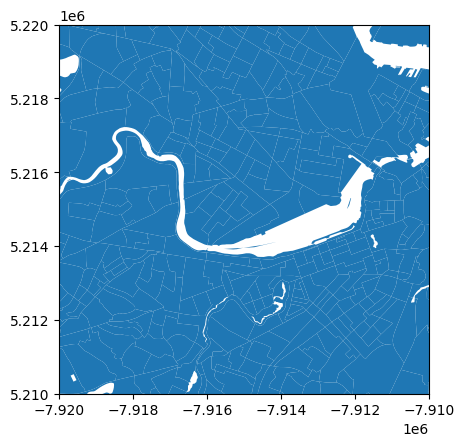

In [4]:
import matplotlib.pyplot as plt

ax = df_geos['blockgroup'].plot()
ax.set_xlim(-7.92e6, -7.91e6)
ax.set_ylim(5.21e6, 5.22e6)
plt.show()

### Download Census Data Tables

We now download the non-geographic American Community Survey (ACS) data tables.

For now, we will retrieve our pre-specified data fields in [TODO], on population totals, race, income, commutes, and household vehicle ownership. They are specified in [census_fields_config.py](census_fields_config.py). Later sections will describe how you can modify it to fetch your own fields of interest.

In [5]:
from census_fields_config import CENSUS_FIELDS_CATEGORIES

We now use a helper function ``get_census_fields`` in [``hackathon_utils.py``](hackathon_utils.py) to retrieve and compute the requested fields.

Reminder: Make sure you've set ``CENSUS_API_KEY`` above as [your free API key](https://api.census.gov/data/key_signup.html)!



In [7]:
from hackathon_utils import get_census_fields

df_census = {}  # Stores DataFrames with census data for each geography level

for geo in GEO_LEVELS:
    df_census[geo] = get_census_fields(
        CENSUS_FIELDS_CATEGORIES,
        CENSUS_API_KEY,
        level=geo, state='MA', 
        compute_ratios=True
    )

This gives us DataFrames with census data as shown below. Note that they do not contain any geometries.

In [8]:
df_census['blockgroup']

,GEOID,population_2020,race_white,race_white_ratio,race_nonWhite,race_nonWhite_ratio,race_black,race_black_ratio,race_native,race_native_ratio,...,commute_timeTransit45,commute_timeTransit45_ratio,commute_timeTransit60,commute_timeTransit60_ratio,vehicles_householdTotal,vehicles_householdTotal_ratio,vehicles_0inHousehold,vehicles_0inHousehold_ratio,vehicles_0or1inHousehold,vehicles_0or1inHousehold_ratio
0,250010101001,992,878,0.885081,114,0.114919,36,0.036290,0,0.000000,...,0,0.000000,0,0.000000,676,1.0,89,0.131657,452,0.668639
1,250010101002,637,568,0.891680,69,0.108320,23,0.036107,3,0.004710,...,0,0.000000,0,0.000000,257,1.0,0,0.000000,104,0.404669
2,250010101003,642,544,0.847352,98,0.152648,26,0.040498,4,0.006231,...,0,0.000000,0,0.000000,374,1.0,68,0.181818,295,0.788770
3,250010101004,729,617,0.846365,112,0.153635,75,0.102881,5,0.006859,...,8,0.048485,8,0.048485,237,1.0,45,0.189873,132,0.556962
4,250010101005,664,557,0.838855,107,0.161145,40,0.060241,9,0.013554,...,0,0.000000,0,0.000000,490,1.0,0,0.000000,274,0.559184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5111,250277614012,785,689,0.877707,96,0.122293,6,0.007643,0,0.000000,...,40,0.198020,40,0.198020,329,1.0,0,0.000000,56,0.170213
5112,250277614013,1194,1017,0.851759,177,0.148241,5,0.004188,0,0.000000,...,0,0.000000,0,0.000000,432,1.0,0,0.000000,150,0.347222
5113,250277614014,1106,998,0.902351,108,0.097649,4,0.003617,3,0.002712,...,7,0.024476,7,0.024476,276,1.0,0,0.000000,24,0.086957
5114,250277614021,1276,1024,0.802508,252,0.197492,35,0.027429,3,0.002351,...,6,0.016620,6,0.016620,344,1.0,15,0.043605,111,0.322674


### Join the (Geo)DataFrames and Compute Density

Finally, we can join the ``GeoDataFrame``'s with Census geometry shapes with the ``DataFrame``s with tabular data. They are joined internally use ``'GEOID'``, a unique numerical ID for each block group.

We black-box the join into the helper function ``join_census_and_add_densities``, which also computes the population density, per square meters, of each data field.

In [9]:
from hackathon_utils import join_census_and_add_densities

df_geodata = {}  # Stores joined GeoDataFrames for each geography level

for geo in GEO_LEVELS:
    df_geodata[geo] = join_census_and_add_densities(
        df_geos[geo], df_census[geo], 
        categories=CENSUS_FIELDS_CATEGORIES  # To infer fields to compute densities for
    )

Here's the merged DataFrame:

In [10]:
df_geodata['place']

,STATEFP,PLACEFP,PLACENS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,PCICBSA,...,commute_timeTransit60_ratio,vehicles_householdTotal,vehicles_householdTotal_density,vehicles_householdTotal_ratio,vehicles_0inHousehold,vehicles_0inHousehold_density,vehicles_0inHousehold_ratio,vehicles_0or1inHousehold,vehicles_0or1inHousehold_density,vehicles_0or1inHousehold_ratio
0,25,00135,02377975,2500135,1600000US2500135,Abington,Abington CDP,57,U1,N,...,0.032088,6438,0.000137,1.0,244,5.197677e-06,0.037900,2277,0.000049,0.353681
1,25,00530,02377976,2500530,1600000US2500530,Acushnet Center,Acushnet Center CDP,57,U2,N,...,0.000000,1371,0.000207,1.0,63,9.529789e-06,0.045952,597,0.000090,0.435449
2,25,00590,02377977,2500590,1600000US2500590,Adams,Adams CDP,57,U1,N,...,0.000000,2970,0.000253,1.0,574,4.892227e-05,0.193266,1743,0.000149,0.586869
3,25,00840,00618180,2500840,1600000US2500840,Agawam Town,Agawam Town city,25,C5,N,...,0.004828,11792,0.000107,1.0,1042,9.480772e-06,0.088365,4867,0.000044,0.412737
4,25,01260,00618292,2501260,1600000US2501260,Amesbury Town,Amesbury Town city,25,C5,N,...,0.013413,7545,0.000127,1.0,457,7.701346e-06,0.060570,3226,0.000054,0.427568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,25,81005,00618335,2581005,1600000US2581005,Winthrop Town,Winthrop Town city,25,C5,N,...,0.054836,7918,0.000836,1.0,911,9.620935e-05,0.115054,4392,0.000464,0.554686
244,25,81035,00619411,2581035,1600000US2581035,Woburn,Woburn city,25,C5,N,...,0.025867,16360,0.000271,1.0,1025,1.697022e-05,0.062653,6971,0.000115,0.426100
245,25,81245,02378051,2581245,1600000US2581245,Woods Hole,Woods Hole CDP,57,U1,N,...,0.023669,540,0.000055,1.0,8,8.094310e-07,0.014815,297,0.000030,0.550000
246,25,82000,00619493,2582000,1600000US2582000,Worcester,Worcester city,25,C5,Y,...,0.014850,79089,0.000447,1.0,12647,7.141889e-05,0.159908,45248,0.000256,0.572115


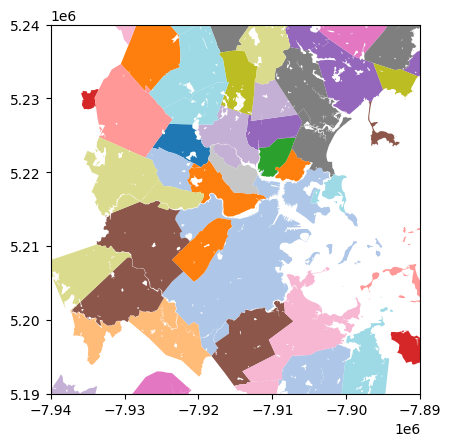

In [11]:
ax = df_geodata['place'].plot(cmap="tab20")
ax.set_xlim(-7.94e6, -7.89e6)
ax.set_ylim(5.19e6, 5.24e6)
plt.show()

### Save as GIS Data

You can save the data locally so that it can be opened in QGIS or ArcGIS. 

The code below writes in GeoPackage format, which allows each ``.gpkg`` file to contain several layers. We name the layers after geographic levels ``"blockgroup"`` and ``"place"``.

In [12]:
import os

OUTPUT_FILEPATH = "data_downloads/demographics.gpkg"
output_dir = os.path.dirname(OUTPUT_FILEPATH)
os.makedirs(output_dir, exist_ok=True)

for geo_name, df in df_geodata.items():
    df.to_file(OUTPUT_FILEPATH, driver='GPKG', layer=geo_name, mode='w')

## Tutorial (Part 2): Specifying Custom Fields in TM Census Importer

To get Census attributes other than those in [``data/demographics.gpkg``](data/demographics.gpkg), you can change the ``CENSUS_FIELDS_CATEGORIES`` dict in [census_fields_config.py](census_fields_config.py). 

Here is a simplified example. Note that when multiple years are specified, the fields will be named with a year prefix, such as ``"2022_commute_rapidTransit"``.

In [13]:
CENSUS_FIELDS_CATEGORIES = {
    "commute": {
        "source": "acs5",  # 5-year American Community Survey
        "years": [2021, 2022, 2023],
        "fields": {
            "bus": ["B08301_011"],  # Individuals taking bus to work
            "rapidTransit": ["B08301_012", "B08301_014"],  # Individuals taking subway (B08301_012) or light rail (B08301_014) to work

            "timeTransit30": ["B08134_067", "B08134_068", "B08134_069", "B08134_070"],  # Individuals with transit commute time 30 minutes or more

            "travelTime": ["B08136_001"],         # Mean travel time to work (minutes)
            "travelTimeTransit": ["B08136_007"],  # Mean travel time to work for public transportation takers (minutes)
        },
        "fields_universe": {  # Define the total universe for computing ratios
            "default": "B08301_001",        # Workers 16 years and over
            "timeTransit30": "B08303_001",  # Workers 16 years and over who did not work from home
            "travelTime": "NO_DENSITY_OR_RATIO",         # Value is mean travel time, cannot compute ratio or density
            "travelTimeTransit": "NO_DENSITY_OR_RATIO",  # Value is mean travel time, cannot compute ratio or density
        }
    },
}


### Find Tables and Field Codes in ACS

The ACS is typically sufficient for most demographic datasets. Detailed documentations for ACS are in the form of [table shells](https://www.census.gov/programs-surveys/acs/technical-documentation/table-shells.2023.html#list-tab-79594641). To find the IDs of tables and variables:

1. Open the "Table Shells and Table List" page linked above.
2. If you want to browse the list of available tables (data products), open the spreadsheet [**"2023 ACS Table List"**](https://www2.census.gov/programs-surveys/acs/tech_docs/table_shells/table_lists/2023_DataProductList.xlsx) linked on the page. This is a condensed sheet with table codes and descriptions.
   * Example: The table ``B08134`` has description ``Means of Transportation to Work by Travel Time to Work``.
   * Not all tables are available for block groups or at the 5-year level. Note the "Year" and "5-Year Geography Restrictions" columns.
3. Go to the main documentation: the spreadsheet [**"2023 ACE Detailed Table Shells"**](https://www2.census.gov/programs-surveys/acs/summary_file/2023/table-based-SF/documentation/ACS2023_Table_Shells.xlsx). Find the field IDs of each demographic group of interest.
   * Example: The field ``B08134_061`` has description ``Public transportation (excluding taxicab):``. This is the number of employed residents in the block group who use public transportation to work, regardless of their travel time to work.
   * Example: Under the aforementioned field, ``B08134_067`` has description ``30 to 34 minutes``. This is the number of employed residents in the block group who use public transportation to work _and_ takes 20-24 minutes to work.
4. Find the field that gives the _universe_ of this table, which is usually the "Total" field with code ``_001``. In this example, the universe is ``Workers 16 years and over who did not work from home``. This may be a subset of total population (excludes unemployed residents and those who work from home). 
5. Record the field IDs of interest (``B08134_067``), together with those that describe the universe (``B08134_001``), to use in the dict above.

![ACS2023 Table Shells showing table B08134 (means of transportation by travel time)](images/acs_table_shell_b08134.png)

Now return to Python and enter the field codes:

* The ``"fields"`` dict stores the IDs that we actually want for the new column. Multiple values will be summed, such as ``"timeTransit30": ["B08134_067", "B08134_068", "B08134_069", "B08134_070"]``.
* In the ``"fields_universe"`` dict:
  * Each new column name should give a single ID that gives the table's universe (i.e., the denominator in ratio computations). The ``"default"`` entry will be applied if the specific column name (e.g. ``"bus"``) is missing.
  * Alternatively, use ``"NO_DENSITY_OR_RATIO"`` to skip the density and ratio computations for a new column. This is typically done if its value is not a count of residents or households – such as median income or aggregated travel time in minutes.

**Note:** The [Census Bureau web app](https://data.census.gov/map/040XX00US25$1500000/ACSDT5Y2023/B08134/B08134_061E?t=Commuting&d=ACS+5-Year+Estimates+Detailed+Tables&layer=VT_2023_150_00_PY_D1&palette=Blues&loc=42.3450,-71.0629,z10.5828) also gives the six-character table code (``B08134``).

### Find Tables and Field Codes in Other Census Surveys

In the event that you want to use data from [surveys](https://www.census.gov/data/data-tools/survey-explorer/) other than the ACS, such as the Decennial Census, you can find the field codes from the [Census API](https://www.census.gov/data/developers.html).

[This page](https://api.census.gov/data.html) lists all Census datasets for all years: you can find the 2020 Census by searching ``dec› dhc``.

For each dataset:
* The "groups" column links to a list of tables. For example, in the 2020 Census, the table ``P5`` has description ``HISPANIC OR LATINO ORIGIN BY RACE``.
* From there, click on "selected variables" at the right of the group you're interested in. This shows the field IDs of each demographic group of interest. For example: The field ``P5_004N`` has description ``!!Total:!!Not Hispanic or Latino:!!Black or African American alone``.

## Optional: Using Census Blocks (as opposed to block groups)

This tutorial does not fetch data at the Census blocks level due to the vast number of them. If you prefer more granular data, you can tweak the code to fetch the shapes for blocks. Many functions can accept ``'block'`` as an argument, but there may be bugs.

Notes:
* There 102,985 Census blocks in Massachusetts, compared to 5,111 block groups.
* Most American Community Survey (ACS) data fields are not available at the block level. Only the Decennial Census can be used there.
* On our machine, the ``load_census_shapes`` function took 9 minutes to retrieve (and remove water from) all blocks. However, disabling the removal of water bodies can vastly improve efficiency.
* In the data returned by ``load_census_shapes``, the field names for blocks are slightly different from other geometries. Blocks use ``"GEOID20"`` for the block ID and ``"ALAND20"`` for land area in square feet. All other geometries use ``"GEOID"`` and ``"ALAND"`` respectively.

### Matching Blocks to Block Groups via Geocodes

You can match blocks and block groups via their unique geocodes (``GEOID``). 

Each **block group geocode** has 12 digits. For example, the block group that covers the central parts of MIT campus has geocode

``250173531022``

where ``25`` is the Massachusetts state ID, ``017`` is the county ID, ``353102`` is the tract ID, and ``2`` is an index of the block group within the tract.

Each **block geocode** adds 3 digits as suffix:

``250173531022003``

where the suffix ``003`` is the index of this block within the block group.

The map below shows this block group in red, and all its member blocks labeled with their last 3 digits.

![Block group and blocks that cover the central part of MIT campus](images/blocks_geocode_mit.png)